# RCNN

## 基本流程

RCNN算法分为4个步骤

1. 候选区域生成： 一张图像生成1K~2K个候选区域 （采用Selective Search 方法）
2. 特征提取： 对每个候选区域，使用深度卷积网络提取特征 （CNN）
3. 类别判断： 特征送入每一类的SVM 分类器，判别是否属于该类
4. 位置精修： 使用回归器精细修正候选框位置


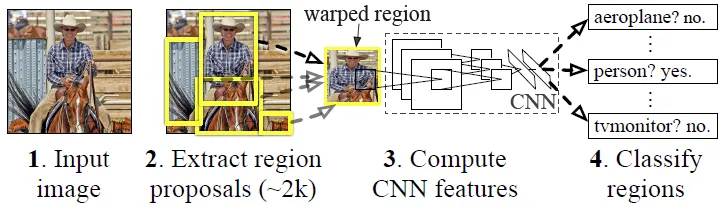

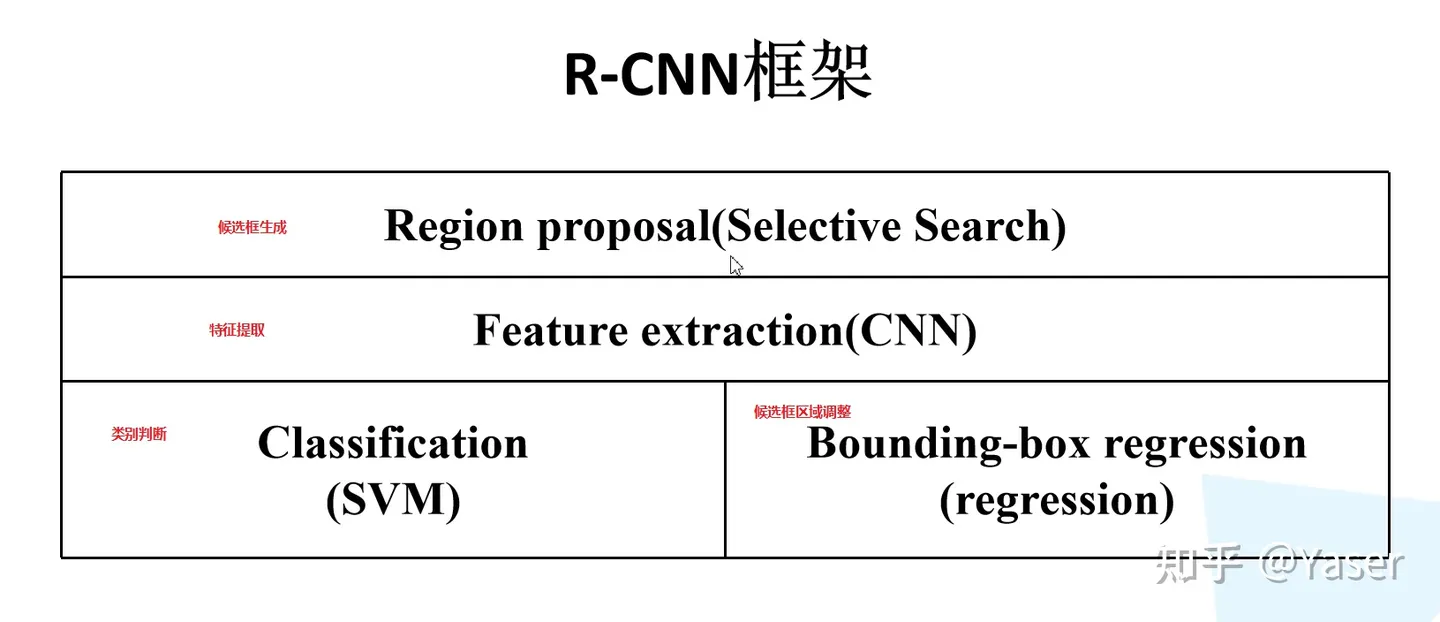

## Selective Search 主要思想:

1. 使用一种过分割手段，将图像分割成小区域 (1k~2k 个)

2. 查看现有小区域，按照合并规则合并可能性最高的相邻两个区域。重复直到整张图像合并成一个区域位置

3. 输出所有曾经存在过的区域，所谓候选区域

其中合并规则如下： 优先合并以下四种区域：

* 颜色（颜色直方图）相近的
* (纹理（梯度直方图）相近的
* 合并后总面积小的： 保证合并操作的尺度较为均匀，避免一个大区域陆续“吃掉”其他小区域 （例：设有区域a-b-c-d-e-f-g-h。较好的合并方式是：ab-cd-ef-gh -> abcd-efgh -> abcdefgh。 不好的合并方法是：ab-c-d-e-f-g-h ->abcd-e-f-g-h ->abcdef-gh -> abcdefgh）
* 合并后，总面积在其BBOX中所占比例大的： 保证合并后形状规则。
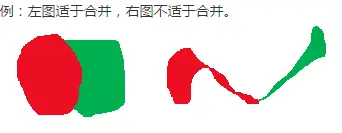
上述四条规则只涉及区域的颜色直方图、梯度直方图、面积和位置。合并后的区域特征可以直接由子区域特征计算而来，速度较快。

## IOU

## 非极大值抑制（NMS）
RCNN会从一张图片中找出n个可能是物体的矩形框，然后为每个矩形框为做类别分类概率：

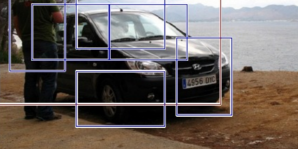

就像上面的图片一样，定位一个车辆，最后算法就找出了一堆的方框，我们需要判别哪些矩形框是没用的。非极大值抑制的方法是：先假设有6个矩形框，根据分类器的类别分类概率做排序，假设从小到大属于车辆的概率 分别为A、B、C、D、E、F。

(1)从最大概率矩形框F开始，分别判断A~E与F的重叠度IOU是否大于某个设定的阈值;

(2)假设B、D与F的重叠度超过阈值，那么就扔掉B、D；并标记第一个矩形框F，是我们保留下来的。

(3)从剩下的矩形框A、C、E中，选择概率最大的E，然后判断E与A、C的重叠度，重叠度大于一定的阈值，那么就扔掉；并标记E是我们保留下来的第二个矩形框。

就这样一直重复，找到所有被保留下来的矩形框。

非极大值抑制（NMS）顾名思义就是**抑制不是极大值的元素，搜索局部的极大值**。这个局部代表的是一个邻域，邻域有两个参数可变，一是邻域的维数，二是邻域的大小。这里不讨论通用的NMS算法，而是用于在目标检测中用于提取分数最高的窗口的。例如在行人检测中，滑动窗口经提取特征，经分类器分类识别后，每个窗口都会得到一个分数。但是滑动窗口会导致很多窗口与其他窗口存在包含或者大部分交叉的情况。这时就需要用到NMS来选取那些邻域里分数最高（是行人的概率最大），并且抑制那些分数低的窗口。

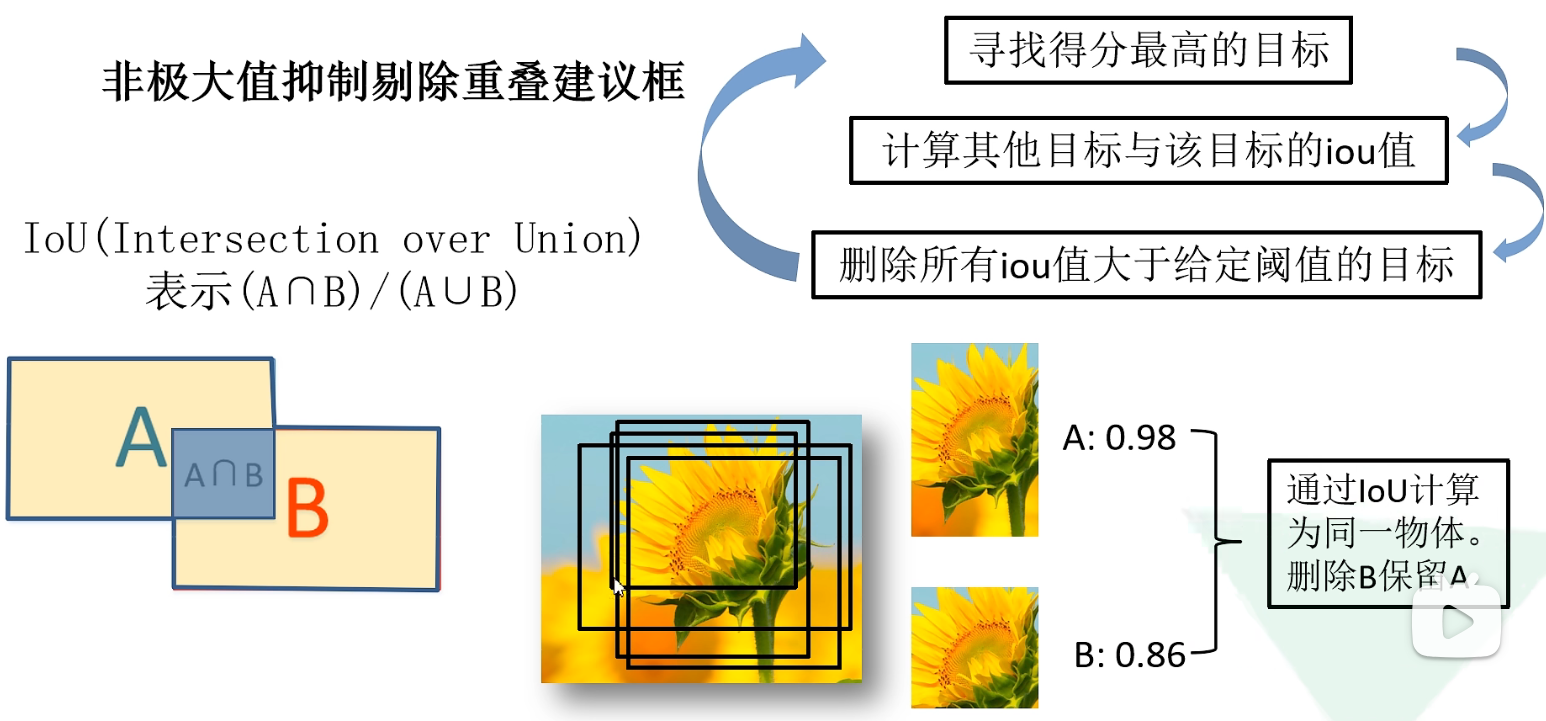

## 候选框搜索阶段：

当我们输入一张图片时，我们要搜索出所有可能是物体的区域，这里采用的就是前面提到的Selective Search方法，通过这个算法我们搜索出2000个候选框。然后从上面的总流程图中可以看到，搜出的候选框是矩形的，而且是**大小各不相同**。然而**CNN对输入图片的大小是有固定的**，如果把搜索到的矩形选框不做处理，就扔进CNN中，肯定不行。因此对于每个输入的候选框都需要缩放到固定的大小。下面我们讲解要怎么进行缩放处理，为了简单起见我们假设下一阶段CNN所需要的输入图片大小是个正方形图片227 * 227。因为我们经过selective search 得到的是矩形框，paper试验了两种不同的处理方法：

(1)各向异性缩放

这种方法很简单，就是不管图片的长宽比例，管它是否扭曲，进行缩放就是了，全部缩放到CNN输入的大小227 * 227，如下图(D)所示；

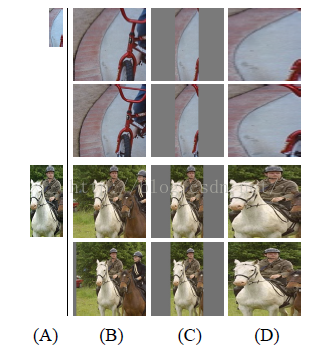

(2)各向同性缩放

因为图片扭曲后，估计会对后续CNN的训练精度有影响，于是作者也测试了“各向同性缩放”方案。有两种办法

A、先扩充后裁剪： 直接在原始图片中，把bounding box的边界进行扩展延伸成正方形，然后再进行裁剪；如果已经延伸到了原始图片的外边界，那么就用bounding box中的颜色均值填充；如上图(B)所示;

B、先裁剪后扩充：先把bounding box图片裁剪出来，然后用固定的背景颜色填充成正方形图片(背景颜色也是采用bounding box的像素颜色均值),如上图(C)所示;

对于上面的异性、同性缩放，文献还有个padding处理，上面的示意图中第1、3行就是结合了padding=0,第2、4行结果图采用padding=16的结果。经过最后的试验，作者发现采用各向异性缩放、padding=16的精度最高。

### CNN特征提取阶段

a、网络结构设计阶段

网络架构两个可选方案：第一选择经典的Alexnet；第二选择VGG16。经过测试Alexnet精度为58.5%，VGG16精度为66%。VGG这个模型的特点是选择比较小的卷积核、选择较小的跨步，这个网络的精度高，不过计算量是Alexnet的7倍。后面为了简单起见，我们就直接选用Alexnet，并进行讲解；Alexnet特征提取部分包含了5个卷积层、2个全连接层，在Alexnet中p5层神经元个数为9216、 f6、f7的神经元个数都是4096，通过这个网络训练完毕后，最后提取特征每个输入候选框图片都能得到一个4096维的特征向量。
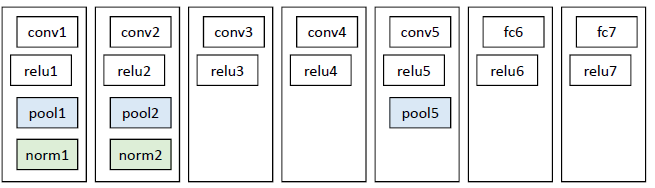

b、网络有监督预训练阶段 （图片数据库：ImageNet ILSVC ）

参数初始化部分：物体检测的一个难点在于，物体标签训练数据少，如果要直接采用随机初始化CNN参数的方法，那么目前的训练数据量是远远不够的。这种情况下，最好的是采用某些方法，把参数初始化了，然后在进行有监督的参数微调，这里文献采用的是有监督的预训练。所以paper在设计网络结构的时候，是直接用Alexnet的网络，然后连参数也是直接采用它的参数，作为初始的参数值，然后再fine-tuning训练。网络优化求解时采用随机梯度下降法，学习率大小为0.001；

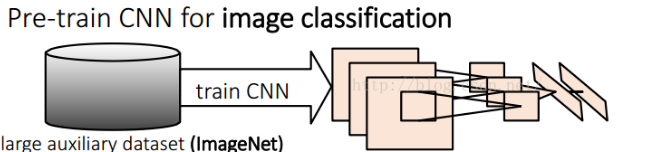

fine-tuning阶段 （图片数据库： PASCAL VOC）

我们接着采用 selective search 搜索出来的候选框 （PASCAL VOC 数据库中的图片） 继续对上面预训练的CNN模型进行fine-tuning训练。假设要检测的物体类别有N类，那么我们就需要把上面预训练阶段的CNN模型的最后一层给替换掉，替换成N+1个输出的神经元(加1，表示还有一个背景) (20 + 1bg = 21)，然后这一层直接采用参数随机初始化的方法，其它网络层的参数不变；接着就可以开始继续SGD训练了。开始的时候，SGD学习率选择0.001，在每次训练的时候，我们batch size大小选择128，其中32个是正样本、96个是负样本。

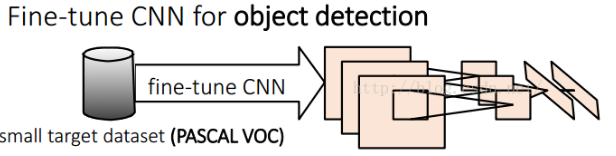

### 关于正负样本的问题
一张照片我们得到了2000个候选框。然而人工标注的数据一张图片中就只标注了正确的bounding box，我们搜索出来的2000个矩形框也不可能会出现一个与人工标注完全匹配的候选框。因此在CNN阶段我们需要用IOU为2000个bounding box打标签。如果用selective search挑选出来的候选框与物体的人工标注矩形框（PASCAL VOC的图片都有人工标注）的**重叠区域IoU大于0.5，那么我们就把这个候选框标注成物体类别（正样本），否则我们就把它当做背景类别（负样本）。**

### 疑惑点： 
CNN训练的时候，本来就是对bounding box的物体进行识别分类训练，在训练的时候最后一层softmax就是分类层。那么为什么作者闲着没事干要先用CNN做特征提取（提取fc7层数据），然后再把提取的特征用于训练svm分类器？

这个是因为svm训练和cnn训练过程的正负样本定义方式各有不同，导致最后采用CNN softmax输出比采用svm精度还低。事情是这样的，cnn在训练的时候，对训练数据做了比较宽松的标注，比如一个bounding box可能只包含物体的一部分，那么我也把它标注为正样本，用于训练cnn；采用这个方法的主要原因在于因为CNN容易过拟合，所以需要大量的训练数据，所以在CNN训练阶段我们是对Bounding box的位置限制条件限制的比较松(IOU只要大于0.5都被标注为正样本了)；然而svm训练的时候，因为svm适用于少样本训练，所以对于训练样本数据的IOU要求比较严格，我们只有当bounding box把整个物体都包含进去了，我们才把它标注为物体类别，然后训练svm

## SVM训练、测试阶段

训练阶段：

这是一个二分类问题，我么假设我们要检测车辆。我们知道只有当bounding box把整量车都包含在内，那才叫正样本；如果bounding box 没有包含到车辆，那么我们就可以把它当做负样本。但问题是当我们的检测窗口只有部分包含物体，那该怎么定义正负样本呢？作者测试了IOU阈值各种方案数值0,0.1,0.2,0.3,0.4,0.5。最后通过训练发现，如果选择IOU阈值为0.3效果最好（选择为0精度下降了4个百分点，选择0.5精度下降了5个百分点）,即当重叠度小于0.3的时候，我们就把它标注为负样本。一旦CNN f7层特征被提取出来，那么我们将为每个物体类训练一个svm分类器。当我们用CNN提取2000个候选框，可以得到2000*4096这样的特征向量矩阵，然后我们只需要把这样的一个矩阵与svm权值矩阵4096*N点乘(N为分类类别数目，因为我们训练的N个svm，每个svm包含了4096个权值w)，就可以得到结果了。

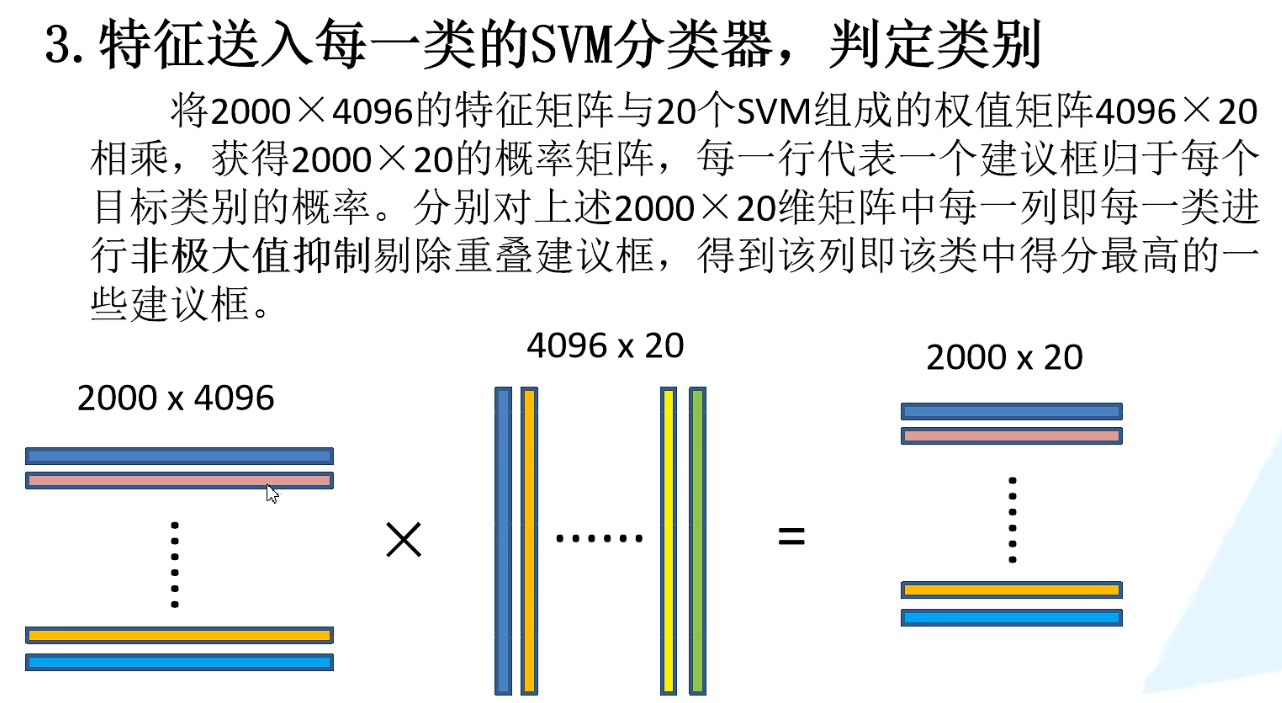

得到的特征输入到SVM进行分类看看这个feature vector所对应的region proposal是需要的物体还是无关的实物(background) 。 排序，canny边界检测之后就得到了我们需要的bounding-box。

## 位置精修

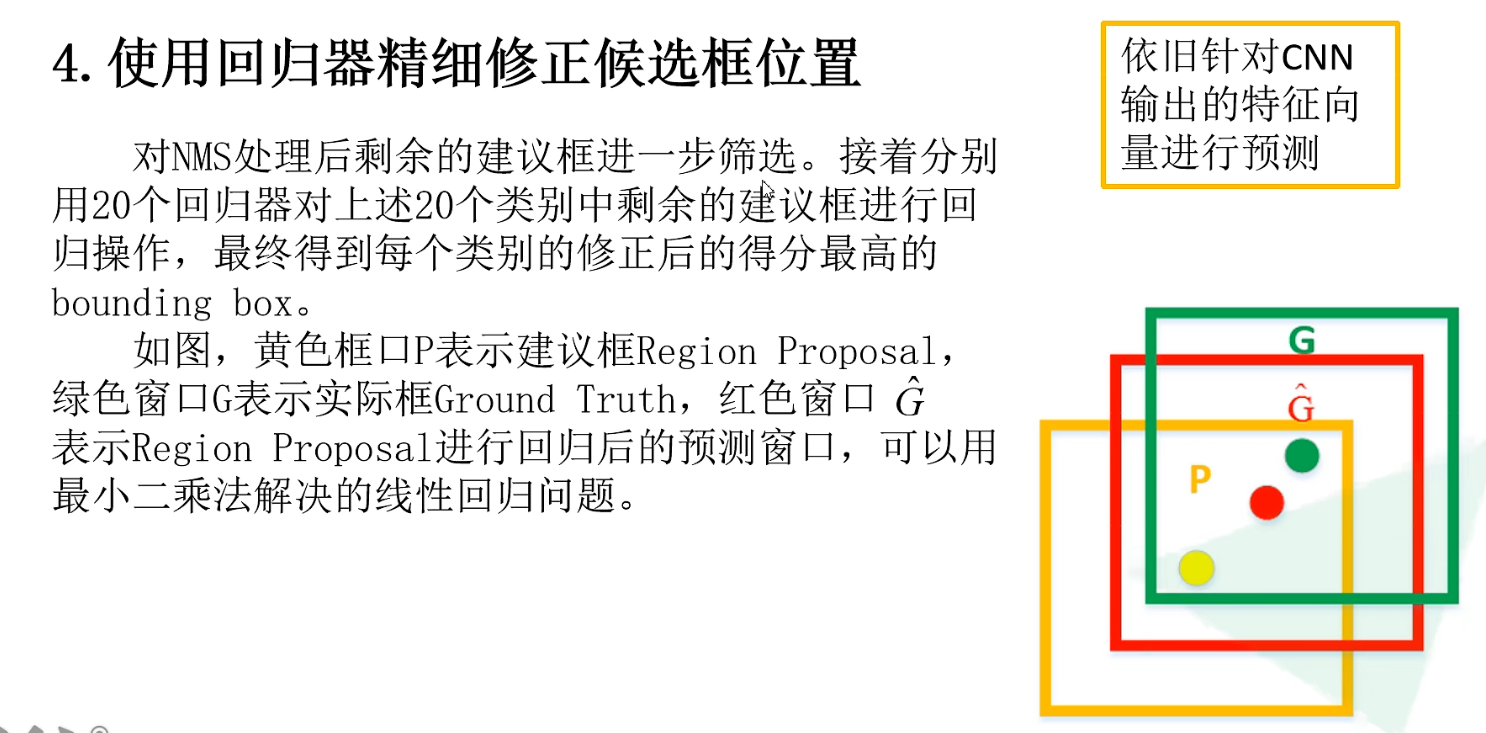

回归器：对每一类目标，使用一个线性回归器进行精修。正则项λ=10000。 输入为深度网络pool5层的4096维特征，输出为xy方向的缩放和平移。 训练样本：判定为本类的候选框中和真值重叠面积大于0.6的候选框

## 测试阶段
使用selective search的方法在测试图片上提取2000个region propasals ，将每个region proposals归一化到227x227，然后再CNN中正向传播，将最后一层得到的特征提取出来。然后对于每一个类别，使用为这一类训练的SVM分类器对提取的特征向量进行打分，得到测试图片中对于所有region proposals的对于这一类的分数，再使用贪心的非极大值抑制（NMS）去除相交的多余的框。再对这些框进行canny边缘检测，就可以得到bounding-box(then B-BoxRegression)。

（非极大值抑制（NMS）先计算出每一个bounding box的面积，然后根据score进行排序，把score最大的bounding box作为选定的框，计算其余bounding box与当前最大score与box的IoU，去除IoU大于设定的阈值的bounding box。然后重复上面的过程，直至候选bounding box为空，然后再将score小于一定阈值的选定框删除得到这一类的结果（然后继续进行下一个分类）。作者提到花费在region propasals和提取特征的时间是13s/张-GPU和53s/张-CPU，可以看出时间还是很长的，不能够达到及时性。

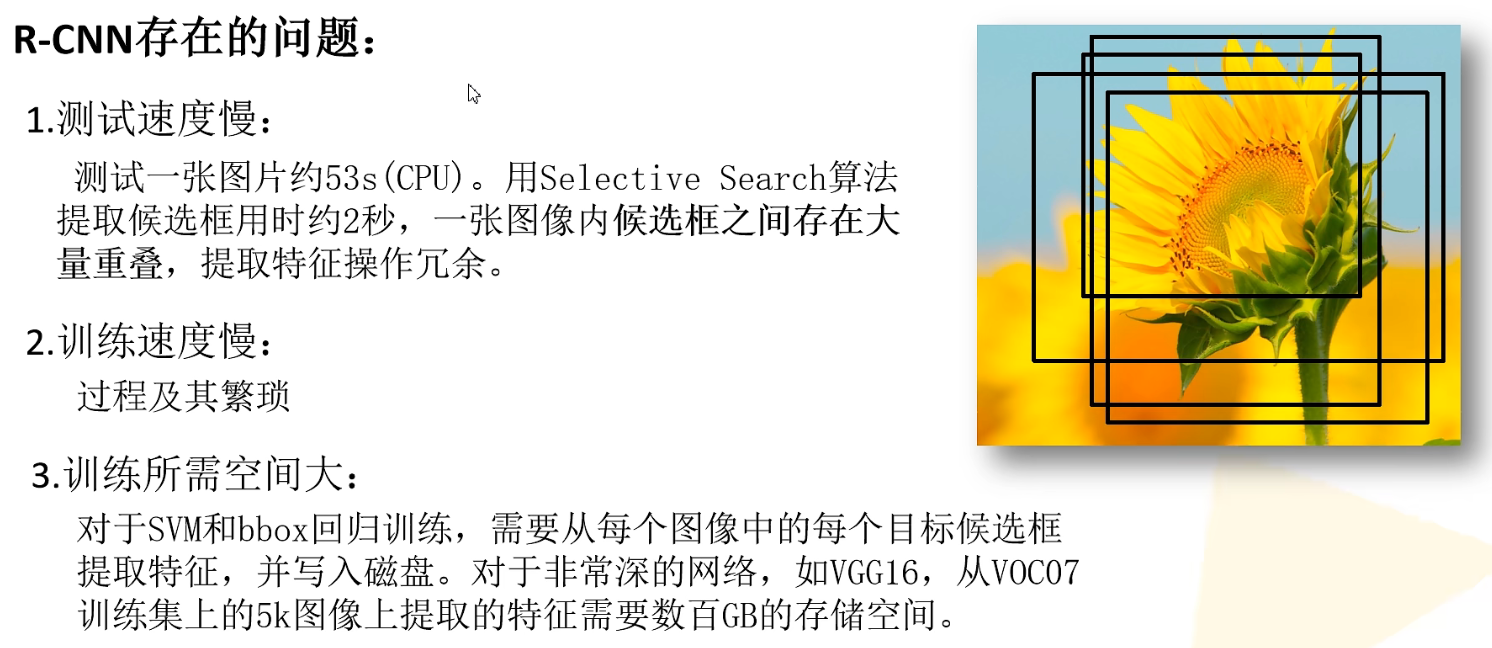